## MLRATE
- https://towardsdatascience.com/variance-reduction-on-steroids-introducing-mlrate-be328cd71a03/

## Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm

rng = np.random.default_rng(seed=42)
n = 10_000

pre_experiment = rng.normal(loc=0, scale=1.5, size=n)
control = pre_experiment + rng.normal(loc=0, scale=1.5, size=n)
treatment = pre_experiment + rng.normal(loc=0.75, scale=1.5, size=n)

df = pd.DataFrame({
    'pre_experiment': np.concatenate([pre_experiment, pre_experiment]),
    'experiment': np.concatenate([control, treatment]),
    'group': [0]*n + [1]*n # ['control']*n + ['treatment']*n
})

In [3]:
# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(control, treatment)

print("ANOVA Results:")
print("F-statistic:", f_stat)
print("p-value:", p_value)

ANOVA Results:
F-statistic: 610.4690334055291
p-value: 8.636214914889958e-133


In [4]:
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.diagnostic import het_breuschpagan

# Fit the model using ordinary least squares (OLS)
model = smf.ols('experiment ~ C(group)', data=df).fit()

# Generate the ANOVA table
anova_results = sm.stats.anova_lm(model, typ=2)

print("\nANOVA Results:")
print(anova_results)


ANOVA Results:
                sum_sq       df           F         PR(>F)
C(group)   2746.165162      1.0  610.469033  8.636215e-133
Residual  89960.027282  19998.0         NaN            NaN


In [5]:
# -----------------------------------------------------------------------------
# Fit the Base ANCOVA Model (without interaction)
# -----------------------------------------------------------------------------
model_ancova = smf.ols('experiment ~ pre_experiment + C(group)', data=df).fit()

# Create the ANOVA table using type II sums of squares.
anova_table = sm.stats.anova_lm(model_ancova, typ=2)

print("ANCOVA Results:")
print(anova_table)

ANCOVA Results:
                      sum_sq       df             F         PR(>F)
C(group)         2746.165162      1.0   1213.193485  4.101428e-258
pre_experiment  44695.141339      1.0  19745.299756   0.000000e+00
Residual        45264.885943  19997.0           NaN            NaN


The p-value for the interaction term `(pre_experiment:C(group))` indicates whether the slopes differ significantly between groups. Ideally, it should be non-significant.

In [6]:
# -----------------------------------------------------------------------------
# Test Homogeneity of Regression Slopes via an Interaction Model
# -----------------------------------------------------------------------------
model_interaction = smf.ols('experiment ~ pre_experiment * C(group)', data=df).fit()
anova_table_interaction = sm.stats.anova_lm(model_interaction, typ=2)

print("\nANCOVA with Interaction Results:")
print(anova_table_interaction)


ANCOVA with Interaction Results:
                               sum_sq       df             F         PR(>F)
C(group)                  2746.165162      1.0   1213.142506  4.204851e-258
pre_experiment           44695.141339      1.0  19744.470041   0.000000e+00
pre_experiment:C(group)      0.361528      1.0      0.159708   6.894295e-01
Residual                 45264.524415  19996.0           NaN            NaN


## ANCOVA Assumptions
https://www.datanovia.com/en/lessons/ancova-in-r/ 

### Linearity & Homogeneity of Slopes:
The scatter plot visually inspects the relationship between pre_experiment and experiment for each group. Regression lines plotted for each group should be roughly linear and, ideally, parallel if homogeneity of slopes holds. The interaction model further tests this numerically.

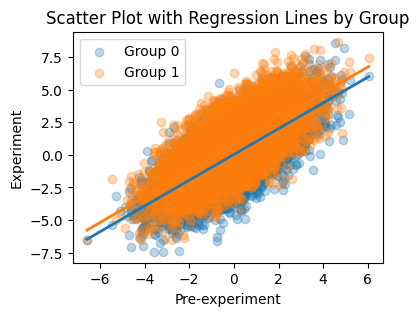

In [7]:
FIGSIZE = (4, 3)

fig, ax = plt.subplots(figsize=FIGSIZE)
groups = df['group'].unique()
colors = ['tab:blue', 'tab:orange']

for idx, group in enumerate(groups):
    subset = df[df['group'] == group]
    # Scatter plot for each group
    ax.scatter(subset['pre_experiment'], subset['experiment'], 
               alpha=0.3, label=f'Group {group}', color=colors[idx])
    # Fit a regression line for each group
    slope, intercept, _, _, _ = stats.linregress(subset['pre_experiment'], subset['experiment'])
    x_vals = np.linspace(subset['pre_experiment'].min(), subset['pre_experiment'].max(), 100)
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, color=colors[idx], lw=2)

ax.set_xlabel('Pre-experiment')
ax.set_ylabel('Experiment')
ax.set_title('Scatter Plot with Regression Lines by Group')
ax.legend()
plt.show()

### Normality of Residuals:
The Q‑Q plot gives a visual check on whether the residuals fall along the line of normality. The Shapiro–Wilk test is reported on a subsample because with very large samples even small deviations become statistically significant.

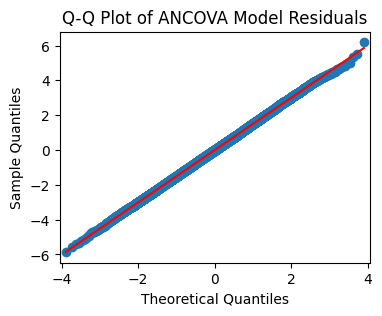


Shapiro-Wilk Test on Residuals (subsample):
Statistic = 0.9993, p-value = 0.0541


In [8]:
residuals = model_ancova.resid

# Q-Q Plot to visualize normality
fig, ax = plt.subplots(figsize=FIGSIZE)
sm.qqplot(residuals, line='s', ax=ax)
ax.set_title('Q-Q Plot of ANCOVA Model Residuals')
plt.show()

# Shapiro-Wilk test on a subsample (for a very large sample, the test can be overly sensitive)
shapiro_stat, shapiro_p = stats.shapiro(residuals[:5000])
print("\nShapiro-Wilk Test on Residuals (subsample):")
print(f"Statistic = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

### Homoscedasticity:
The residuals versus fitted values plot should display an even spread of residuals (no funneling or pattern). The Breusch–Pagan test provides a more formal test for heteroscedasticity.

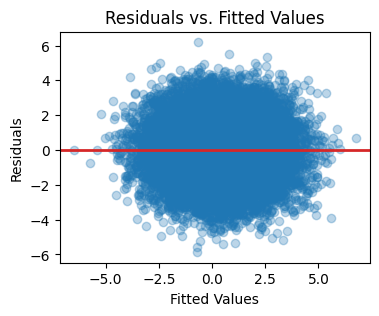


Breusch-Pagan Test for Homoscedasticity:
Lagrange multiplier statistic = 0.5357, p-value = 0.7650


In [9]:
# Plot residuals vs. fitted values
fitted_vals = model_ancova.fittedvalues
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.scatter(fitted_vals, residuals, alpha=0.3)
ax.axhline(y=0, color='tab:red', lw=2)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs. Fitted Values')
plt.show()

# Breusch-Pagan test for heteroscedasticity
bp_test_stat, bp_test_p, _, _ = het_breuschpagan(residuals, model_ancova.model.exog)
print("\nBreusch-Pagan Test for Homoscedasticity:")
print(f"Lagrange multiplier statistic = {bp_test_stat:.4f}, p-value = {bp_test_p:.4f}")

### Outliers: 
Standardized residuals are computed to identify observations that deviate more than 3 standard deviations from the fitted value, suggesting potential outliers.

In [10]:
influence = OLSInfluence(model_ancova)
standardized_residuals = influence.resid_studentized_internal
# Count the number of observations with |standardized residual| > 3
outliers = np.where(np.abs(standardized_residuals) > 3)[0]
print(f"\nNumber of outliers (|standardized residual| > 3): {len(outliers)}")


Number of outliers (|standardized residual| > 3): 42


## T-Test and OLS

In [6]:
t_stat, p_value = stats.ttest_ind(treatment, control)
print(f"T-test results:")
print(f"   p-value     : {p_value:.6f}")
print(f"   t-statistic : {t_stat:.4f}\n")

X = sm.add_constant(df['group'])
model = sm.OLS(df['experiment'], X).fit()
print(f"OLS results:")
print(f"  p-value     : {model.pvalues['group']:.6f}")
print(f"  t-statistic : {model.tvalues['group']:.4f}")
print(f"  Coefficient : {model.params['group']:.4f}")
print(f"  Std Error   : {model.bse['group']:.4f}")

T-test results:
   p-value     : 0.000000
   t-statistic : 24.7077

OLS results:
  p-value     : 0.000000
  t-statistic : 24.7077
  Coefficient : 0.7411
  Std Error   : 0.0300


Fun fact: the coefficient of the regression can also be found through the difference in means between the treatment and control or by taking ${cov(x,y)}/{var(x)}$.

In [ ]:
print(f"Difference in means: {np.mean(treatment) - np.mean(control):.4f}")
print(f"cov(x,y) / var(x): {np.cov(df['experiment'], X['group'])[0, 1] / np.var(X['group']):.4f}")

Difference in means: 0.7411
cov(x,y) / var(x): 0.7411


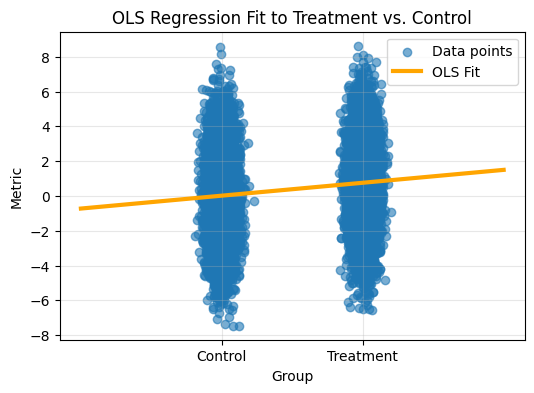

In [328]:
plt.figure(figsize=(6, 4))

# Scatter plot of data points
plt.scatter(df['group'] + rng.normal(scale=0.05, size=2*n),  # jitter for clarity
            df['experiment'],
            alpha=0.6,
            label='Data points')

# Regression line
group_vals = np.array([-1, 2])
predicted_vals = model.predict(sm.add_constant(group_vals))
plt.plot(group_vals, predicted_vals, color='orange', linewidth=3, label='OLS Fit')
plt.xticks([0, 1], ['Control', 'Treatment'])
plt.xlabel('Group')
plt.ylabel('Metric')
plt.title('OLS Regression Fit to Treatment vs. Control')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Difference-in-Difference
- https://www.publichealth.columbia.edu/research/population-health-methods/difference-difference-estimation

$$ \text{DiD estimate} = (\text{Treatment}_{post} - \text{Treatment}_{pre}) - (\text{Control}_{post} - \text{Control}_{pre}) $$
$$ Y = \beta_0 + \beta_1 * \text{Time} + \beta_2 * \text{Intervention} + \beta_3 * \text{Time} * \text{Intervention} + \beta_4 * \text{Covariates} + \epsilon $$

In [302]:
df_long = pd.DataFrame({
    'metric': np.concatenate([pre_experiment, control, pre_experiment, treatment]),
    'group': ['control']*n*2 + ['treatment']*n*2,
    'period': ['pre']*n + ['post']*n + ['pre']*n + ['post']*n
})

# Encode categorical variables
df_long['group_encoded'] = (df_long['group'] == 'treatment').astype(int)
df_long['period_encoded'] = (df_long['period'] == 'post').astype(int)

# Interaction term (group * period)
df_long['interaction'] = df_long['group_encoded'] * df_long['period_encoded']

# display(df_long)

# Fit DiD regression model
X_did = sm.add_constant(df_long[['group_encoded', 'period_encoded', 'interaction']])
model_did = sm.OLS(df_long['metric'], X_did).fit()

print(f"Difference-in-Difference (DiD) results:")
print(f"  DiD Coefficient : {model_did.params['interaction']:.4f}")
print(f"  Std Error       : {model_did.bse['interaction']:.4f}")
print(f"  t-statistic     : {model_did.tvalues['interaction']:.4f}")
print(f"  p-value         : {model_did.pvalues['interaction']:.6f}\n")

# Interpretation:
print("Interpretation:")
print(f"The DiD coefficient ({model_did.params['interaction']:.4f}) represents the estimated treatment effect,")
print(f"adjusting for pre-experiment differences and common trends over time.")


Difference-in-Difference (DiD) results:
  DiD Coefficient : 0.7411
  Std Error       : 0.0368
  t-statistic     : 20.1300
  p-value         : 0.000000

Interpretation:
The DiD coefficient (0.7411) represents the estimated treatment effect,
adjusting for pre-experiment differences and common trends over time.


The DiD coefficient is the same as just taking the mean differences. The benefit of the linear model is that we can do statistical inference (p-value / std error).

In [ ]:
# Full equation: (treatment.mean() - control.mean()) - (pre_experiment.mean() - pre_experiment.mean())
# Simplifies to: (treatment.mean() - control.mean())
(treatment.mean() - control.mean()) - (pre_experiment.mean() - pre_experiment.mean())

0.7411025787993734

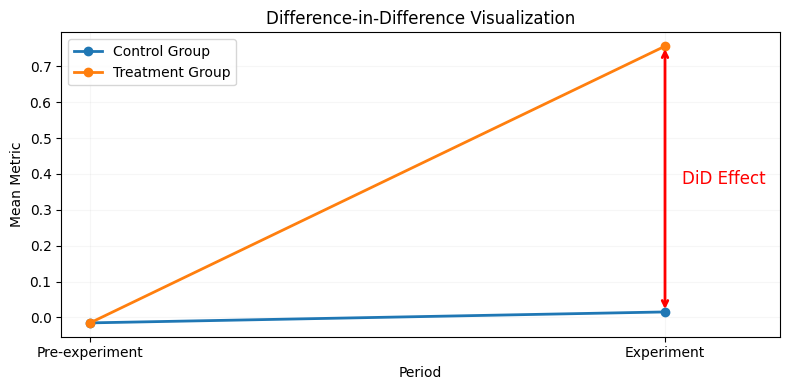

In [327]:
means = {
    'Pre-experiment': {
        'control': np.mean(pre_experiment),
        'treatment': np.mean(pre_experiment)  # identical by design in pre-period
    },
    'Experiment': {
        'control': np.mean(control),
        'treatment': np.mean(treatment)
    }
}

fig, ax = plt.subplots(figsize=(8, 4))

# Numeric positions for x-coordinates
x_coords = [0, 1]

# Plot Control and Treatment lines
ax.plot(x_coords,
        [means['Pre-experiment']['control'], means['Experiment']['control']],
        marker='o', label='Control Group', linestyle='-', linewidth=2)

ax.plot(x_coords,
        [means['Pre-experiment']['treatment'], means['Experiment']['treatment']],
        linestyle='-', marker='o', linewidth=2, label='Treatment Group')

# Annotate DiD effect
ax.annotate('', xy=(1, means['Experiment']['treatment']),
            xytext=(1, means['Experiment']['control']),
            arrowprops=dict(arrowstyle='<->', color='red', linewidth=2))

# Slightly offset text to the right (e.g., +0.03)
ax.text(1 + 0.03,
        (means['Experiment']['treatment'] + means['Experiment']['control']) / 2,
        'DiD Effect', va='center', ha='left', fontsize=12, color='red')

# Set custom x-ticks and labels
ax.set_xticks(x_coords)
ax.set_xticklabels(['Pre-experiment', 'Experiment'])
ax.set_xlim(x_coords[0]-0.05, x_coords[1]+0.2)
ax.set_xlabel('Period')
ax.set_ylabel('Mean Metric')
ax.set_title('Difference-in-Difference Visualization')
ax.legend()
ax.grid(alpha=0.1)
plt.tight_layout()
plt.show()

## CUPED
- https://matteocourthoud.github.io/post/cuped/
- https://medium.com/towards-data-science/how-to-double-a-b-testing-speed-with-cuped-f80460825a90


CUPED works by adjusting observed outcomes with pre-experiment covariates to reduce variance. The optimal covariate is often the same metric from the pre-experiment period.

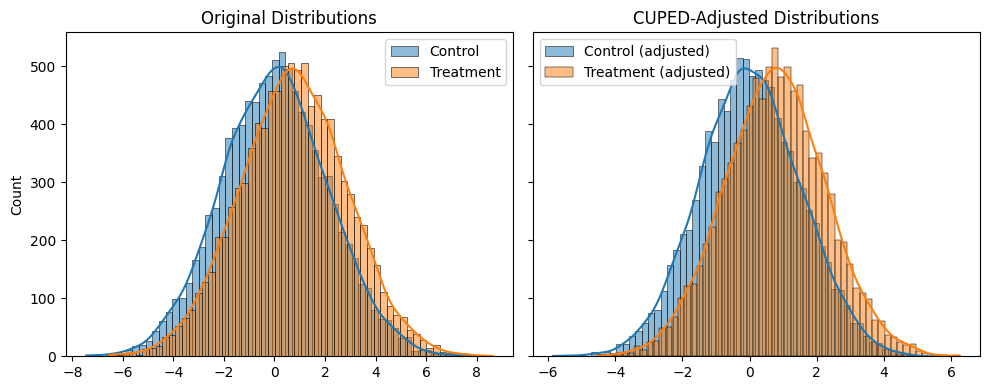

In [286]:
# Compute theta (optimal regression coefficient)
theta = np.cov(control, pre_experiment)[0, 1] / np.var(pre_experiment)

# Adjust metrics using CUPED
control_adjusted = control - theta * (pre_experiment - np.mean(pre_experiment))
treatment_adjusted = treatment - theta * (pre_experiment - np.mean(pre_experiment))

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

sns.histplot(control, label='Control', ax=axes[0], kde=True)
sns.histplot(treatment, label='Treatment', ax=axes[0], kde=True)
axes[0].legend()
axes[0].set_title("Original Distributions")

sns.histplot(control_adjusted, label='Control (adjusted)', ax=axes[1], kde=True)
sns.histplot(treatment_adjusted, label='Treatment (adjusted)', ax=axes[1], kde=True)
axes[1].legend()
axes[1].set_title("CUPED-Adjusted Distributions")

plt.tight_layout()
plt.show()

In [ ]:
covariate_cols = ['pre_experiment']

# Fit linear regression model on combined data
model = LinearRegression()
model.fit(df[covariate_cols], df['experiment'])

# Adjusted observations
covariates_centered = df[covariate_cols] - df[covariate_cols].mean()
df['experiment_adjusted'] = df['experiment'] - covariates_centered @ model.coef_

# Check variance reduction
var_before = df.groupby('group')['experiment'].var()
var_after = df.groupby('group')['experiment_adjusted'].var()
variance_reduction = 1 - var_after.mean() / var_before.mean()

print(f"Variance reduction: {variance_reduction:.2%}")

# Perform adjusted t-test
control_adj = df[df.group == 0]['experiment_adjusted']
treatment_adj = df[df.group == 1]['experiment_adjusted']

t_stat, p_value = stats.ttest_ind(treatment_adj, control_adj)
print(f"\nAdjusted T-test Results:")
print(f"   p-value     : {p_value:.6f}")
print(f"   t-statistic : {t_stat:.4f}\n")

Variance reduction: 49.68%

Adjusted T-test Results:
   p-value     : 0.000000
   t-statistic : 34.8318



Multiple covariates

In [ ]:
df['browser_type'] = rng.choice(['Chrome', 'Firefox'], size=n*2)
df = pd.get_dummies(df, columns=['browser_type'])

# Define covariates
covariate_cols = ['pre_experiment', 'browser_type_Chrome', 'browser_type_Firefox']

# Fit linear regression model on combined data
model = LinearRegression()
model.fit(df[covariate_cols], df['experiment'])

# Compute adjusted metric
covariates_centered = df[covariate_cols] - df[covariate_cols].mean()
df['experiment_adjusted'] = df['experiment'] - covariates_centered @ model.coef_

# Check variance reduction
var_before = df.groupby('group')['experiment'].var()
var_after = df.groupby('group')['experiment_adjusted'].var()
variance_reduction = 1 - var_after.mean() / var_before.mean()

print("Variance reduction using multiple covariates:", round(variance_reduction * 100, 2), "%")

# Perform adjusted t-test
control_adj = df[df.group == 0]['experiment_adjusted']
treatment_adj = df[df.group == 1]['experiment_adjusted']

t_stat, p_value = stats.ttest_ind(treatment_adj, control_adj)
print(f"\nAdjusted T-test Results:")
print(f"   p-value     : {p_value:.6f}")
print(f"   t-statistic : {t_stat:.4f}\n")

Variance reduction using multiple covariates: 49.68 %

Adjusted T-test Results:
   p-value     : 0.000000
   t-statistic : 34.8314



## Log Transforms
Adding constants in a log transformation can effect the p-value.

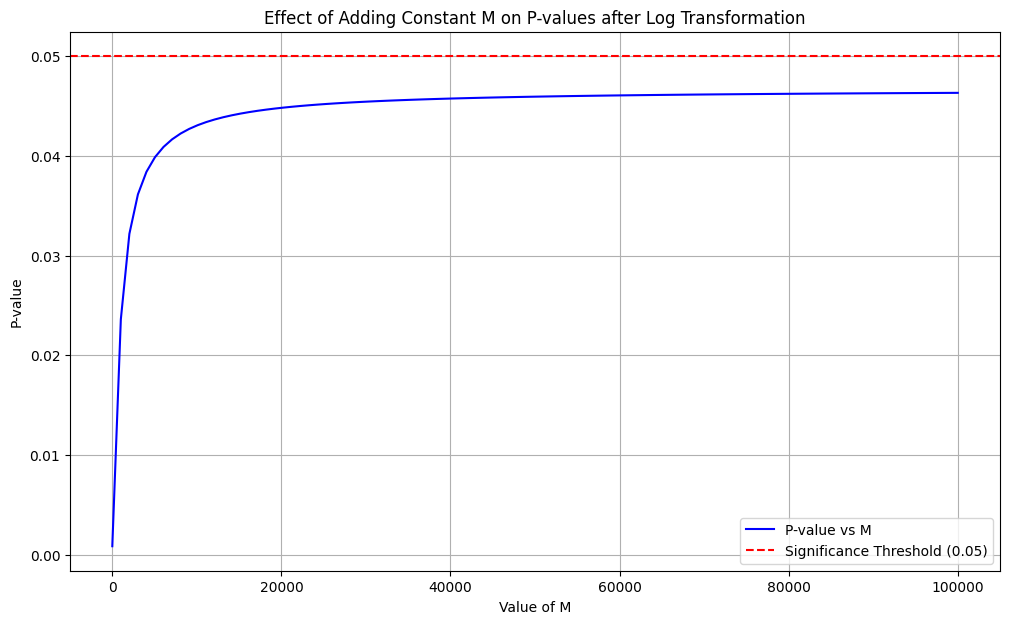

In [11]:
rng = np.random.default_rng(seed=42)
num_simulations = 100

u = rng.normal(loc=0, scale=1, size=num_simulations)
v = rng.normal(loc=1, scale=2, size=num_simulations)

# Generate yi1 and yi2 based on the given formulas
yi1 = np.exp(u) + 15
yi2 = np.exp(v) + 13

# Store p-values
p_values = []

# Calculate p-values for different values of M
M_values = np.linspace(0, 100000, 100)  # Different values of M to test

for M in M_values:
    y1_transformed = np.log(yi1 + M)
    y2_transformed = np.log(yi2 + M)
    _, p_value = stats.ttest_ind(y1_transformed, y2_transformed)
    p_values.append(p_value)

# Plot the results
plt.figure(figsize=(12, 7))
plt.plot(M_values, p_values, label='P-value vs M', color='b')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.xlabel('Value of M')
plt.ylabel('P-value')
plt.title('Effect of Adding Constant M on P-values after Log Transformation')
plt.legend()
plt.grid(True)
plt.show()